In [4]:
%%writefile sim_module.cpp
#include <iostream>
#include <vector>
#include <array>
#include <cmath>
#include <cstdlib>
#include <limits>

// ----------------- Derivative Function -----------------
// Returns an array containing: [w1, w2, v, w1_2, w2_2, v_2]
std::array<double, 6> derv(double theta1, double theta2, double x,
                           double w1, double w2, double v,
                           double l1, double l2, double R,
                           double k, double c_x)
{
    const double g = 1.0; // gravity constant

    double sin_theta1 = std::sin(theta1);
    double cos_theta1 = std::cos(theta1);
    double sin_theta2 = std::sin(theta2);
    double cos_theta2 = std::cos(theta2);

    double a = g * (sin_theta1 * cos_theta1 + sin_theta2 * cos_theta2);
    double b = l2 * (w2 * w2) * sin_theta2 + l1 * (w1 * w1) * sin_theta1;
    double c = R + 2 - (cos_theta1 * cos_theta1) - (cos_theta2 * cos_theta2);
    double v_2 = (a + b - c_x * v - k * x) / c; // dv/dt
    double w1_2 = (g * sin_theta1 + v_2 * cos_theta1) * (-1.0 / l1); // dw1/dt
    double w2_2 = (g * sin_theta2 + v_2 * cos_theta2) * (-1.0 / l2); // dw2/dt

    return {w1, w2, v, w1_2, w2_2, v_2};
}

// ----------------- RK4 Integrator -----------------
// Returns a vector of states. Each state is an array of 7 doubles:
// [theta1, theta2, w1, w2, x, v, t]
std::vector<std::array<double, 7>> rk4(double theta1, double theta2, double w1,
                                       double w2, double x, double v,
                                       double l1, double l2, double R,
                                       double k, double c_x,
                                       double dt, int N)
{
    std::vector<std::array<double, 7>> result;
    result.reserve(N);

    for (int i = 0; i < N; i++) {
        result.push_back({theta1, theta2, w1, w2, x, v, dt * i});

        auto f0 = derv(theta1, theta2, x, w1, w2, v, l1, l2, R, k, c_x);
        auto f1 = derv(theta1 + f0[0] * (dt / 2.0),
                       theta2 + f0[1] * (dt / 2.0),
                       x      + f0[2] * (dt / 2.0),
                       w1     + f0[3] * (dt / 2.0),
                       w2     + f0[4] * (dt / 2.0),
                       v      + f0[5] * (dt / 2.0),
                       l1, l2, R, k, c_x);
        auto f2 = derv(theta1 + f1[0] * (dt / 2.0),
                       theta2 + f1[1] * (dt / 2.0),
                       x      + f1[2] * (dt / 2.0),
                       w1     + f1[3] * (dt / 2.0),
                       w2     + f1[4] * (dt / 2.0),
                       v      + f1[5] * (dt / 2.0),
                       l1, l2, R, k, c_x);
        auto f3 = derv(theta1 + f2[0] * dt,
                       theta2 + f2[1] * dt,
                       x      + f2[2] * dt,
                       w1     + f2[3] * dt,
                       w2     + f2[4] * dt,
                       v      + f2[5] * dt,
                       l1, l2, R, k, c_x);

        theta1 += (f0[0] + 2 * f1[0] + 2 * f2[0] + f3[0]) * dt / 6.0;
        theta2 += (f0[1] + 2 * f1[1] + 2 * f2[1] + f3[1]) * dt / 6.0;
        x      += (f0[2] + 2 * f1[2] + 2 * f2[2] + f3[2]) * dt / 6.0;
        w1     += (f0[3] + 2 * f1[3] + 2 * f2[3] + f3[3]) * dt / 6.0;
        w2     += (f0[4] + 2 * f1[4] + 2 * f2[4] + f3[4]) * dt / 6.0;
        v      += (f0[5] + 2 * f1[5] + 2 * f2[5] + f3[5]) * dt / 6.0;
    }

    return result;
}

// ----------------- Linear Regression Helper -----------------
// Computes the slope of a line fit to (x,y) data points.
double linear_regression_slope(const std::vector<double>& x, const std::vector<double>& y) {
    size_t n = x.size();
    if (n == 0) return std::numeric_limits<double>::quiet_NaN();
    double sum_x = 0.0, sum_y = 0.0, sum_xy = 0.0, sum_xx = 0.0;
    for (size_t i = 0; i < n; i++) {
        sum_x += x[i];
        sum_y += y[i];
        sum_xy += x[i] * y[i];
        sum_xx += x[i] * x[i];
    }
    double denominator = n * sum_xx - sum_x * sum_x;
    if (denominator == 0.0) return std::numeric_limits<double>::quiet_NaN();
    return (n * sum_xy - sum_x * sum_y) / denominator;
}

// ----------------- Compute Largest Lyapunov Exponent -----------------
// Uses two trajectories (base and perturbed) and computes the exponent from
// the linear regime of log(separation) vs time.
double compute_largest_lyapunov(double theta1, double theta2,
                                double w1, double w2,
                                double x, double v,
                                double l1, double l2,
                                double R, double k, double c_x,
                                double dt, int N,
                                double perturb_threshold = 1e-2)
{
    // Base initial state
    std::array<double, 6> state0 = {theta1, theta2, w1, w2, x, v};
    // Perturb theta1 slightly
    double perturbation = 1e-6;
    std::array<double, 6> state0_pert = state0;
    state0_pert[0] += perturbation;

    // Run simulation for base trajectory
    auto simData1 = rk4(state0[0], state0[1], state0[2], state0[3], state0[4], state0[5],
                        l1, l2, R, k, c_x, dt, N);
    // Run simulation for perturbed trajectory
    auto simData2 = rk4(state0_pert[0], state0_pert[1], state0_pert[2], state0_pert[3],
                        state0_pert[4], state0_pert[5],
                        l1, l2, R, k, c_x, dt, N);

    // We'll compute the Euclidean distance (over 6 state variables) at each time step.
    std::vector<double> times;
    std::vector<double> log_differences;
    for (size_t i = 0; i < simData1.size(); i++) {
        // Compute Euclidean norm for state (indices 0..5)
        double sum_sq = 0.0;
        for (int j = 0; j < 6; j++) {
            double diff = simData1[i][j] - simData2[i][j];
            sum_sq += diff * diff;
        }
        double dist = std::sqrt(sum_sq);
        // Use only if distance is below threshold (linear regime)
        if (dist < perturb_threshold && dist > 0) {
            times.push_back(simData1[i][6]); // time is at index 6
            log_differences.push_back(std::log(dist));
        }
    }

    // If not enough points, return NaN.
    if (times.size() < 10) {
        return std::numeric_limits<double>::quiet_NaN();
    }

    // Compute the slope of log(distance) vs time.
    double slope = linear_regression_slope(times, log_differences);
    return slope;
}

// ----------------- Main -----------------
// This program loops over a range of R values and prints out CSV lines with:
// R, largest Lyapunov exponent
int main(int argc, char* argv[])
{
    // We'll use fixed initial conditions for other variables:
    double theta1_0 = 0.2;
    double theta2_0 = -1;
    double w1_0 = 0.0;
    double w2_0 = 0.0;
    double x0 = 0.0;
    double v0 = 0.0;

    // Fixed system parameters (except R)
    double l1 = 1.0;
    double l2 = 1.0;
    double k = 0.0;
    double c_x = 0.0;
    double dt = 0.002;
    int N = 2000000;  // number of steps

    // Range of R values:
    double R_min = 10;
    double R_max = 20;
    int num_R = 50;

    // Print CSV header
    std::cout << "R,lyapunov_exponent" << std::endl;

    // Loop over R values.
    for (int i = 0; i < num_R; i++) {
        double R = R_min + i * (R_max - R_min) / (num_R - 1);
        double lyap = compute_largest_lyapunov(theta1_0, theta2_0, w1_0, w2_0, x0, v0,
                                               l1, l2, R, k, c_x, dt, N, 1e-2);
        std::cout << R << "," << lyap << std::endl;
    }

    return 0;
}


Overwriting sim_module.cpp


In [5]:
!g++ -O3 -march=native -flto -ffast-math -std=c++11 -o lyapunov_sim sim_module.cpp



         R  lyapunov_exponent
0  10.0000           0.000739
1  10.2041           0.000740
2  10.4082           0.000740
3  10.6122           0.000740
4  10.8163           0.000740


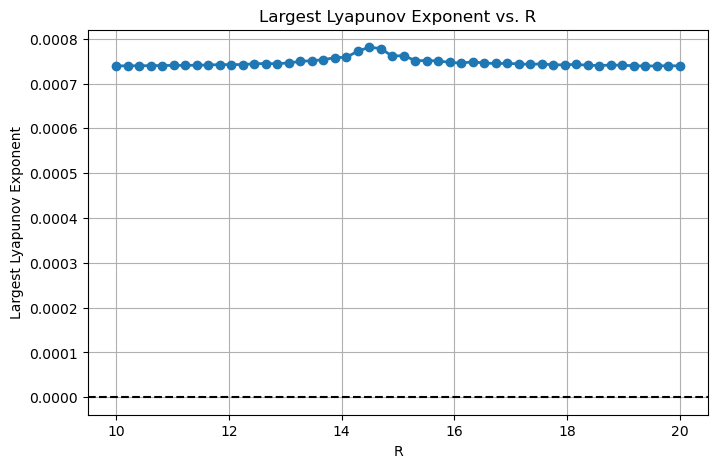

In [60]:
import subprocess
import pandas as pd
import io

# Path to the compiled executable
exe_path = "./lyapunov_sim"

# Run the executable and capture its output
result = subprocess.run([exe_path],
                        encoding='utf-8',
                        capture_output=True)

if result.returncode != 0:
    print("Error running simulation:", result.stderr)
else:
    # Read the CSV output into a DataFrame
    data = result.stdout
    df = pd.read_csv(io.StringIO(data))
    print(df.head())
    # Now you can plot or analyze the Lyapunov exponent vs R:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,5))
    plt.plot(df['R'], df['lyapunov_exponent'], 'o-', lw=2)
    plt.axhline(0, color='k', ls='--')
    plt.xlabel("R")
    plt.ylabel("Largest Lyapunov Exponent")
    plt.title("Largest Lyapunov Exponent vs. R")
    plt.grid(True)
    plt.show()


In [ ]:
0  0.560000           0.002871
1  0.562105           0.002875
2  0.564211           0.002880
3  0.566316           0.002884
4  0.568421           0.002888
double dt = 0.0005;
    int N = 2000000;  // number of steps

In [ ]:
0  0.560000           0.001467
1  0.562105           0.001468
2  0.564211           0.001469
3  0.566316           0.001470
4  0.568421           0.001471
double dt = 0.004;
    int N = 500000;  // number of steps

# Poincare Section

In [61]:
%%writefile sim.cpp
// sim_module.cpp
#include <iostream>
#include <vector>
#include <array>
#include <cmath>
#include <cstdlib>
#include <limits>
#include <string>

// ----------------- Derivative Function -----------------
// Returns an array containing: [w1, w2, v, w1_2, w2_2, v_2]
std::array<double, 6> derv(double theta1, double theta2, double x,
                           double w1, double w2, double v,
                           double l1, double l2, double R,
                           double k, double c_x)
{
    const double g = 1.0; // gravity constant

    double sin_theta1 = std::sin(theta1);
    double cos_theta1 = std::cos(theta1);
    double sin_theta2 = std::sin(theta2);
    double cos_theta2 = std::cos(theta2);

    double a = g * (sin_theta1 * cos_theta1 + sin_theta2 * cos_theta2);
    double b = l2 * (w2 * w2) * sin_theta2 + l1 * (w1 * w1) * sin_theta1;
    double c = R + 2 - (cos_theta1 * cos_theta1) - (cos_theta2 * cos_theta2);
    double v_2 = (a + b - c_x * v - k * x) / c; // dv/dt
    double w1_2 = (g * sin_theta1 + v_2 * cos_theta1) * (-1.0 / l1); // dw1/dt
    double w2_2 = (g * sin_theta2 + v_2 * cos_theta2) * (-1.0 / l2); // dw2/dt

    return {w1, w2, v, w1_2, w2_2, v_2};
}

// ----------------- RK4 Integrator -----------------
// Returns a vector of states. Each state is an array of 7 doubles:
// [theta1, theta2, w1, w2, x, v, t]
std::vector<std::array<double, 7>> rk4(double theta1, double theta2, double w1,
                                       double w2, double x, double v,
                                       double l1, double l2, double R,
                                       double k, double c_x,
                                       double dt, int N)
{
    std::vector<std::array<double, 7>> result;
    result.reserve(N);

    for (int i = 0; i < N; i++) {
        result.push_back({theta1, theta2, w1, w2, x, v, dt * i});

        auto f0 = derv(theta1, theta2, x, w1, w2, v, l1, l2, R, k, c_x);
        auto f1 = derv(theta1 + f0[0] * (dt / 2.0),
                       theta2 + f0[1] * (dt / 2.0),
                       x      + f0[2] * (dt / 2.0),
                       w1     + f0[3] * (dt / 2.0),
                       w2     + f0[4] * (dt / 2.0),
                       v      + f0[5] * (dt / 2.0),
                       l1, l2, R, k, c_x);
        auto f2 = derv(theta1 + f1[0] * (dt / 2.0),
                       theta2 + f1[1] * (dt / 2.0),
                       x      + f1[2] * (dt / 2.0),
                       w1     + f1[3] * (dt / 2.0),
                       w2     + f1[4] * (dt / 2.0),
                       v      + f1[5] * (dt / 2.0),
                       l1, l2, R, k, c_x);
        auto f3 = derv(theta1 + f2[0] * dt,
                       theta2 + f2[1] * dt,
                       x      + f2[2] * dt,
                       w1     + f2[3] * dt,
                       w2     + f2[4] * dt,
                       v      + f2[5] * dt,
                       l1, l2, R, k, c_x);

        theta1 += (f0[0] + 2 * f1[0] + 2 * f2[0] + f3[0]) * dt / 6.0;
        theta2 += (f0[1] + 2 * f1[1] + 2 * f2[1] + f3[1]) * dt / 6.0;
        x      += (f0[2] + 2 * f1[2] + 2 * f2[2] + f3[2]) * dt / 6.0;
        w1     += (f0[3] + 2 * f1[3] + 2 * f2[3] + f3[3]) * dt / 6.0;
        w2     += (f0[4] + 2 * f1[4] + 2 * f2[4] + f3[4]) * dt / 6.0;
        v      += (f0[5] + 2 * f1[5] + 2 * f2[5] + f3[5]) * dt / 6.0;
    }

    return result;
}

// ----------------- Poincaré Section Extraction -----------------
// This function mimics the Python function provided:
// It loops over the simulation data (assumed to be stored in a vector of state arrays)
// and for each index k (starting from 1), if the condition variable (e.g., theta_j)
// at index k-1 is negative and at index k is positive, and if the condition_rate
// (e.g., omega_j) at index k is positive, it records the corresponding values
// of the variables (var_i and var_j).
std::pair<std::vector<double>, std::vector<double>> poincare_section_simple(
    const std::vector<std::array<double, 7>>& data,
    int condition_var,   // index for condition variable (e.g., 1 for theta2)
    int condition_rate,  // index for condition rate (e.g., 3 for ω₂)
    int var_i,           // index for variable of interest (e.g., 0 for theta1)
    int var_j            // index for variable of interest (e.g., 2 for ω₁)
) {
    std::vector<double> poincare_theta;
    std::vector<double> poincare_omega;
    // Loop from k=1 to end.
    for (size_t k = 1; k < data.size(); k++) {
        double prev = data[k - 1][condition_var];
        double curr = data[k][condition_var];
        double curr_rate = data[k][condition_rate];
        // Check the crossing condition: previous value < 0, current value > 0, and condition rate > 0.
        if (prev < 0 && curr > 0 && curr_rate > 0) {
            // Record the values directly (without interpolation) as in the Python code.
            poincare_theta.push_back(data[k][var_i]);
            poincare_omega.push_back(data[k][var_j]);
        }
    }
    return std::make_pair(poincare_theta, poincare_omega);
}

// ----------------- Main -----------------
// This program runs a simulation for a set of R values, extracts Poincaré sections
// and prints CSV-formatted output with the columns:
// R, section, x_value, y_value
// where "section" is 1 for one Poincaré section (e.g., using theta2 crossing condition)
// and 2 for the other.
int main()
{
    // Fixed simulation parameters:
    double theta1 = 0.3;
    double theta2 = 0.9;
    double w1 = 0.0;
    double w2 = 0.0;
    double x = 0.0;
    double v = 0.0;
    double l1 = 1.0;
    double l2 = 1.0;
    double k = 0.0;
    double c_x = 0.0;
    double dt = 0.001;
    int N = 4000000;  // number of steps

    // Define a set of R values
    std::vector<double> R_values;
    // Use a small epsilon to ensure we include 20.0 due to floating-point issues.
    for (double r = 0.5; r <= 0.7 + 1e-9; r += 0.01) {
        R_values.push_back(r);
    }

    // Print CSV header
    std::cout << "R,section,x_value,y_value" << std::endl;

    // Loop over each R value.
    for (size_t i = 0; i < R_values.size(); i++) {
        double R = R_values[i];
        // Run simulation with the given R value.
        std::vector<std::array<double, 7>> simData = rk4(theta1, theta2, w1, w2, x, v,
                                                         l1, l2, R, k, c_x, dt, N);

        // Extract Section 1:
        // When theta2 (index 1) crosses 0 (with w2 (index 3) > 0),
        // record (theta1, w1) (indices 0 and 2).
        auto section1 = poincare_section_simple(simData, 1, 3, 0, 2);

        // Extract Section 2:
        // When theta1 (index 0) crosses 0 (with w1 (index 2) > 0),
        // record (theta2, w2) (indices 1 and 3).
//         auto section2 = poincare_section_simple(simData, 0, 2, 1, 3);

        // Output all points from Section 1 with section id = 1.
        for (size_t j = 0; j < section1.first.size(); j++) {
            std::cout << R << "," << 1 << "," << section1.first[j] << "," << section1.second[j] << std::endl;
        }
        // Output all points from Section 2 with section id = 2.
//         for (size_t j = 0; j < section2.first.size(); j++) {
//             std::cout << R << "," << 2 << "," << section2.first[j] << "," << section2.second[j] << std::endl;
//         }
    }

    return 0;
}


Overwriting sim.cpp


In [62]:
!g++ -O3 -std=c++11 -o sim_module sim.cpp


Data preview:
   R  section   x_value   y_value
0 -2        1 -0.240244 -0.639184
1 -2        1 -0.240279 -0.639180
2 -2        1 -0.240314 -0.639176
3 -2        1 -0.240349 -0.639172
4 -2        1 -0.240384 -0.639168


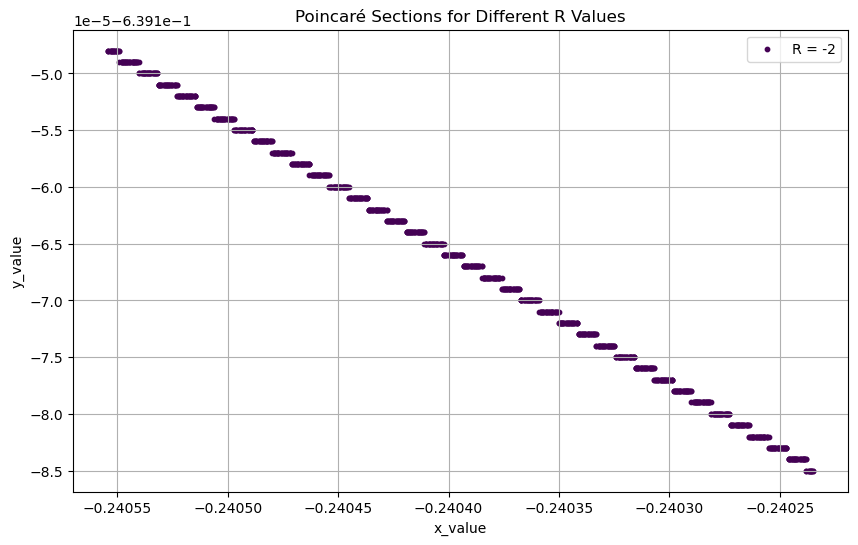

CPU times: total: 109 ms
Wall time: 10 s


In [63]:
%%time
import subprocess
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np

# Run the C++ executable and capture its output
result = subprocess.run(["./sim_module"], capture_output=True, text=True)
if result.returncode != 0:
    print("Error running simulation:", result.stderr)
    exit(1)

# Read the CSV output into a DataFrame
csv_output = result.stdout
df = pd.read_csv(io.StringIO(csv_output))
print("Data preview:")
print(df.head())

# Create a plot and group by R value
plt.figure(figsize=(10, 6))

# Get the unique R values and sort them
unique_R = np.sort(df['R'].unique())

# Generate a color map (using viridis) for each R value
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_R)))

for i, r_val in enumerate(unique_R):
    df_r = df[df['R'] == r_val]
    # Plot both sections for the given R value
    plt.scatter(df_r['x_value'], df_r['y_value'], s=10, color=colors[i], label=f"R = {r_val}")

plt.xlabel("x_value")
plt.ylabel("y_value")
plt.title("Poincaré Sections for Different R Values")
plt.legend()
plt.grid(True)
plt.show()


Data preview:
     R  section   x_value  y_value
0  0.0        1 -0.393458  1.83127
1  0.0        1 -0.505470  1.22660
2  0.0        1 -0.438222  1.59320
3  0.0        1 -0.460803  1.41832
4  0.0        1 -0.488028  1.36919


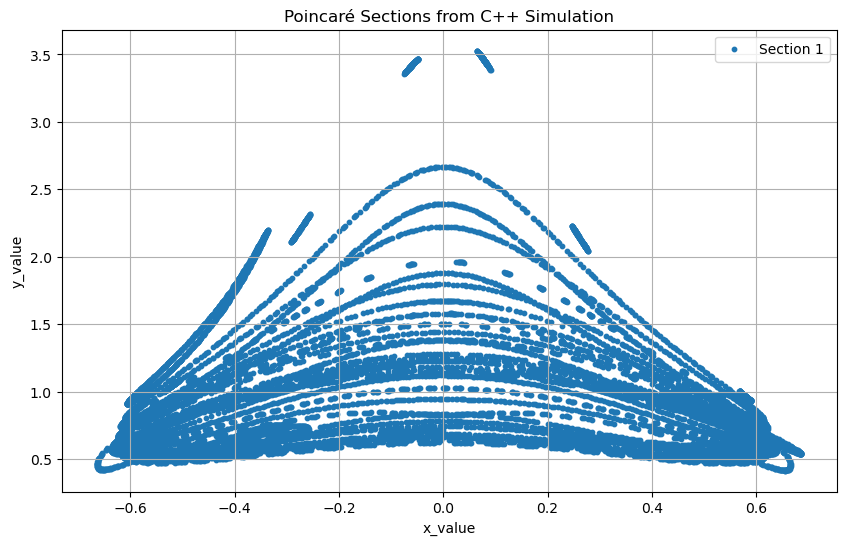

In [17]:
import subprocess
import pandas as pd
import io
import matplotlib.pyplot as plt

# Run the C++ executable and capture its output as a string.
result = subprocess.run(["./sim_module"], capture_output=True, text=True)
if result.returncode != 0:
    print("Error running the simulation:")
    print(result.stderr)
    exit(1)

# The output is in CSV format.
csv_data = result.stdout

# Load the CSV data into a pandas DataFrame.
# The C++ code prints a header: "R,section,x_value,y_value"
df = pd.read_csv(io.StringIO(csv_data))
print("Data preview:")
print(df.head())

# Plotting the Poincaré sections.
# We can plot points from each section (using different markers/colors for section 1 and 2)
plt.figure(figsize=(10, 6))
sections = df['section'].unique()
for sec in sections:
    df_sec = df[df['section'] == sec]
    plt.scatter(df_sec['x_value'], df_sec['y_value'], s=10, label=f"Section {sec}")
    break

plt.xlabel("x_value")
plt.ylabel("y_value")
plt.title("Poincaré Sections from C++ Simulation")
plt.legend()
plt.grid(True)
plt.show()


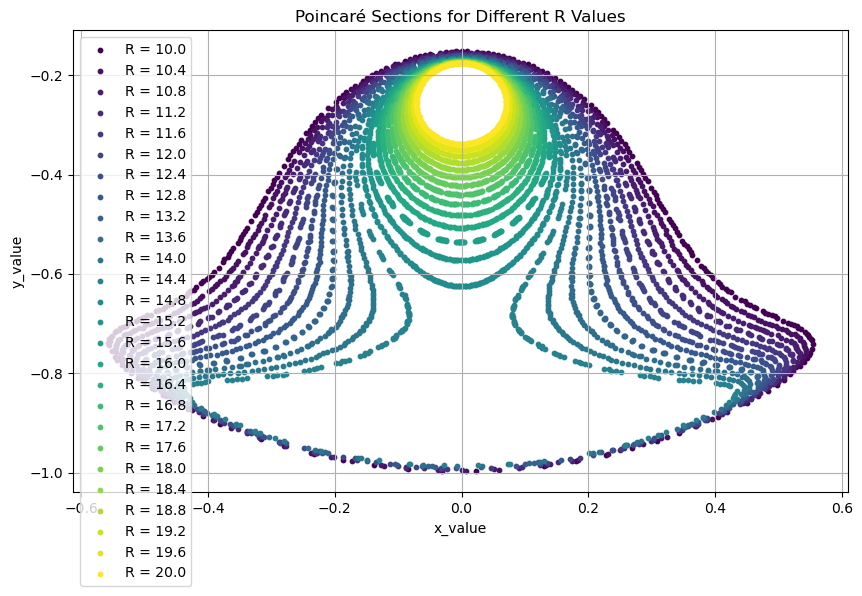

In [57]:
# Create a plot and group by R value
plt.figure(figsize=(10, 6))

# Get the unique R values and sort them
unique_R = np.sort(df['R'].unique())

# Generate a color map (using viridis) for each R value
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_R)))
for i, r_val in enumerate(unique_R):
    df_r = df[df['R'] == r_val]
    # Plot both sections for the given R value
    plt.scatter(df_r['x_value'], df_r['y_value'], s=10, color=colors[i], label=f"R = {r_val}")

plt.xlabel("x_value")
plt.ylabel("y_value")
plt.title("Poincaré Sections for Different R Values")
plt.legend()
plt.grid(True)
plt.show()

Data preview:
      R  section   x_value   y_value
0  10.2        1  0.032318 -0.155020
1  10.2        1  0.149391 -0.211147
2  10.2        1  0.235830 -0.314113
3  10.2        1  0.293849 -0.428052
4  10.2        1  0.338682 -0.532222


C:\Users\bluni\AppData\Local\Temp\ipykernel_18836\928033714.py:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


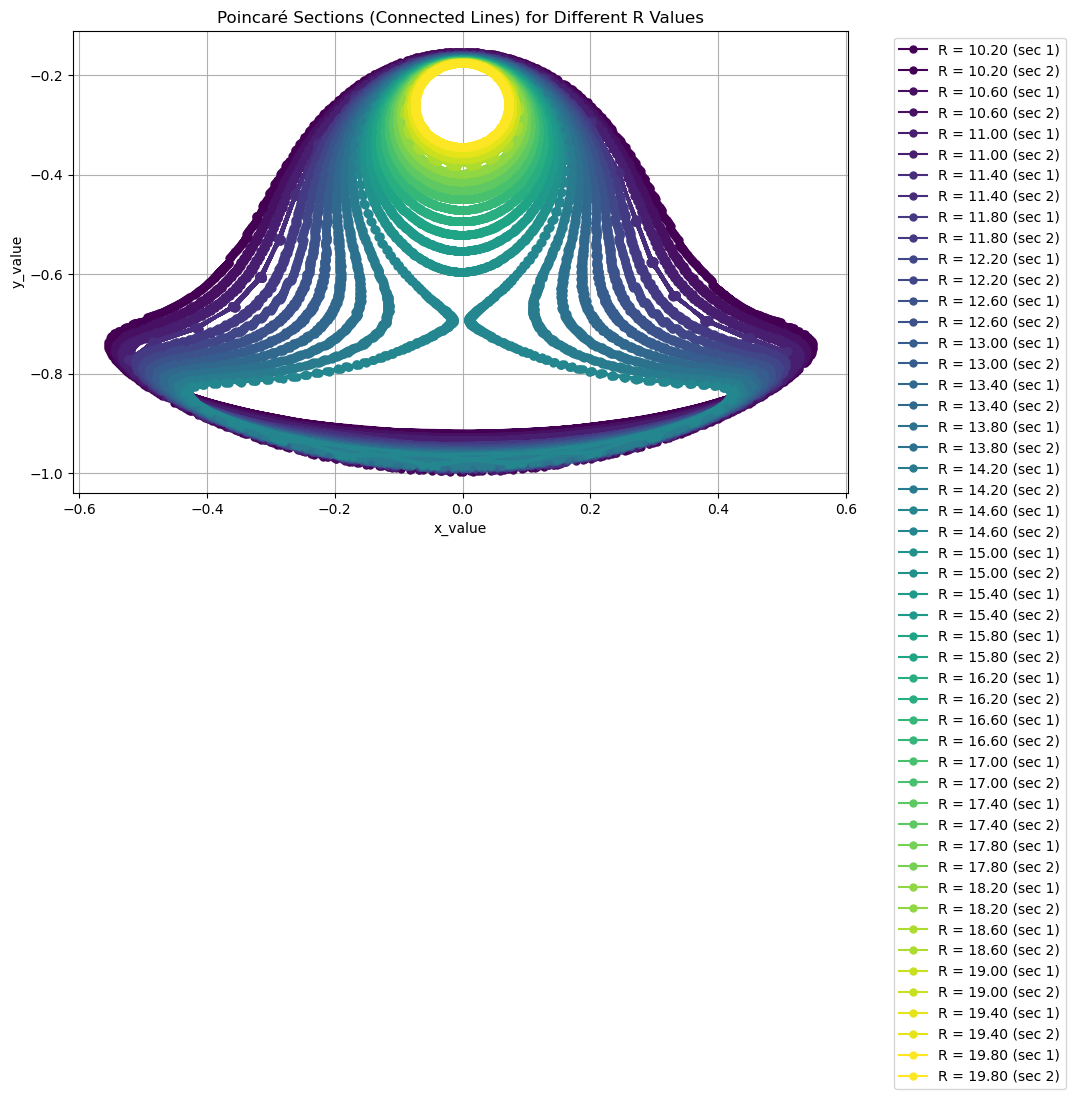

In [70]:
import subprocess
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np

# Run the C++ executable and capture its output
result = subprocess.run(["./sim_module"], capture_output=True, text=True)
if result.returncode != 0:
    print("Error running simulation:", result.stderr)
    exit(1)

# Read CSV output into a DataFrame
csv_output = result.stdout
df = pd.read_csv(io.StringIO(csv_output))
print("Data preview:")
print(df.head())

# Plot the Poincaré sections with lines for each R value.
plt.figure(figsize=(10, 6))

# Get unique R values and sort them
unique_R = np.sort(df['R'].unique())

# Use a colormap (e.g., viridis)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_R)))

# Loop over each R value and plot the points for each section
for i, r_val in enumerate(unique_R):
    df_r = df[df['R'] == r_val]
    # Optionally, sort by time if available (if not, remove the sort)
    # df_r = df_r.sort_values(by="t")
    
    # Plot points from section 1 for this R value as a line with markers
    df_sec1 = df_r[df_r['section'] == 1]
    plt.plot(df_sec1['x_value'], df_sec1['y_value'], 'o-', markersize=5,
             color=colors[i], label=f"R = {r_val:.2f} (sec 1)")
    
    # Plot points from section 2 for this R value as a line with markers
    df_sec2 = df_r[df_r['section'] == 2]
    plt.plot(df_sec2['x_value'], df_sec2['y_value'], 'o-', markersize=5,
             color=colors[i], label=f"R = {r_val:.2f} (sec 2)")

plt.xlabel("x_value")
plt.ylabel("y_value")
plt.title("Poincaré Sections (Connected Lines) for Different R Values")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


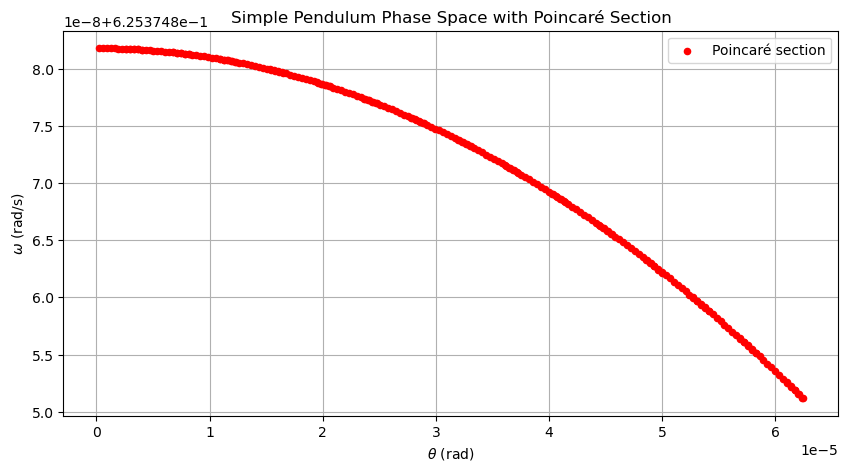

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def pendulum_derivs(theta, omega, g, l):
    """
    Returns the derivatives dtheta/dt and domega/dt for a simple pendulum.
    """
    dtheta_dt = omega
    domega_dt = - (g / l) * np.sin(theta)
    return dtheta_dt, domega_dt

def rk4_step(theta, omega, dt, g, l):
    """
    Perform one RK4 step for the simple pendulum.
    Inputs:
      theta, omega : current state
      dt           : time step
      g, l         : gravitational accel, pendulum length
    Returns:
      (theta_new, omega_new)
    """
    k1_theta, k1_omega = pendulum_derivs(theta, omega, g, l)
    k2_theta, k2_omega = pendulum_derivs(theta + 0.5*k1_theta*dt,
                                         omega  + 0.5*k1_omega*dt, g, l)
    k3_theta, k3_omega = pendulum_derivs(theta + 0.5*k2_theta*dt,
                                         omega  + 0.5*k2_omega*dt, g, l)
    k4_theta, k4_omega = pendulum_derivs(theta + k3_theta*dt,
                                         omega  + k3_omega*dt, g, l)
    
    theta_new = theta + (dt/6.0)*(k1_theta + 2*k2_theta + 2*k3_theta + k4_theta)
    omega_new = omega + (dt/6.0)*(k1_omega + 2*k2_omega + 2*k3_omega + k4_omega)
    return theta_new, omega_new

def simulate_pendulum(theta0, omega0, g, l, dt, N):
    """
    Simulates the pendulum using RK4 for N steps of size dt.
    Returns arrays of theta, omega, and time.
    """
    thetas = np.zeros(N)
    omegas = np.zeros(N)
    times  = np.zeros(N)
    
    theta = theta0
    omega = omega0
    
    for i in range(N):
        thetas[i] = theta
        omegas[i] = omega
        times[i]  = i*dt
        theta, omega = rk4_step(theta, omega, dt, g, l)
    
    return thetas, omegas, times

def poincare_section(thetas, omegas, times):
    """
    Extracts Poincaré section points where:
      1) theta crosses from negative to positive
      2) omega > 0 at the crossing index
    Returns arrays of (theta_section, omega_section, time_section).
    """
    theta_sec = []
    omega_sec = []
    time_sec  = []
    
    for k in range(1, len(thetas)):
        if thetas[k-1] < 0 and thetas[k] > 0 and omegas[k] > 0:
            theta_sec.append(thetas[k])
            omega_sec.append(omegas[k])
            time_sec.append(times[k])
    
    return np.array(theta_sec), np.array(omega_sec), np.array(time_sec)

# ------------------- Main Code -------------------
if __name__ == "__main__":
    # Parameters
    g = 9.81    # gravitational acceleration (m/s^2)
    l = 1.0     # pendulum length (m)
    dt = 0.0001   # time step
    N = 5_000_000   # number of steps
    
    # Initial conditions
    theta0 = 0.2    # initial angle (radians)
    omega0 = 0.0    # initial angular velocity
    
    # Simulate
    thetas, omegas, times = simulate_pendulum(theta0, omega0, g, l, dt, N)
    
    # Get Poincaré section
    theta_sec, omega_sec, time_sec = poincare_section(thetas, omegas, times)
    
    # Plot the trajectory in phase space
    plt.figure(figsize=(10,5))
#     plt.plot(thetas, omegas, 'b-', alpha=0.5, label="Phase trajectory")
    # Plot the Poincaré section points
    plt.scatter(theta_sec, omega_sec, color='red', s=20, zorder=3, label="Poincaré section")
    
    plt.xlabel(r"$\theta$ (rad)")
    plt.ylabel(r"$\omega$ (rad/s)")
    plt.title("Simple Pendulum Phase Space with Poincaré Section")
    plt.legend()
    plt.grid(True)
    plt.show()


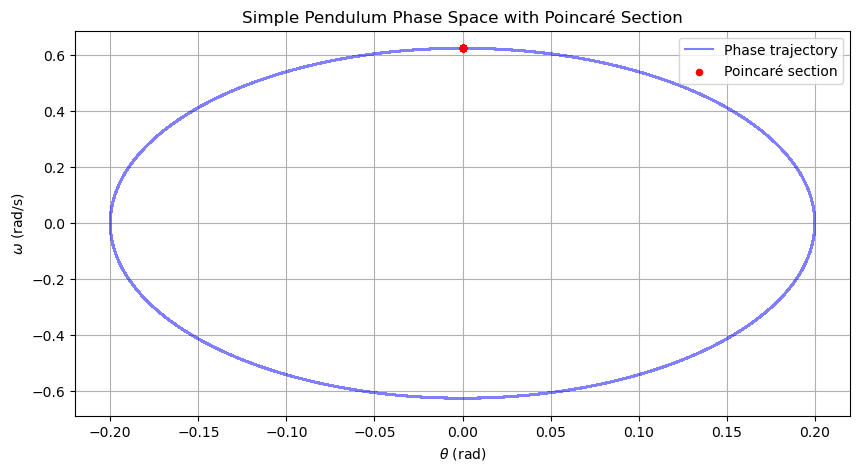

In [9]:
 # Plot the trajectory in phase space
plt.figure(figsize=(10,5))
plt.plot(thetas, omegas, 'b-', alpha=0.5, label="Phase trajectory")
# Plot the Poincaré section points
plt.scatter(theta_sec, omega_sec, color='red', s=20, zorder=3, label="Poincaré section")

plt.xlabel(r"$\theta$ (rad)")
plt.ylabel(r"$\omega$ (rad/s)")
plt.title("Simple Pendulum Phase Space with Poincaré Section")
plt.legend()
plt.grid(True)
plt.show()